# [COM6513] Assignment 2: Topic Classification with a Feedforward Network


### Instructor: Nikos Aletras


The goal of this assignment is to develop a Feedforward neural network for topic classification. 



For that purpose, you will implement:

- Text processing methods for transforming raw text data into input vectors for your network  (**1 mark**)


- A Feedforward network consisting of:
    - **One-hot** input layer mapping words into an **Embedding weight matrix** (**1 mark**)
    - **One hidden layer** computing the mean embedding vector of all words in input followed by a **ReLU activation function** (**1 mark**)
    - **Output layer** with a **softmax** activation. (**1 mark**)


- The Stochastic Gradient Descent (SGD) algorithm with **back-propagation** to learn the weights of your Neural network. Your algorithm should:
    - Use (and minimise) the **Categorical Cross-entropy loss** function (**1 mark**)
    - Perform a **Forward pass** to compute intermediate outputs (**3 marks**)
    - Perform a **Backward pass** to compute gradients and update all sets of weights (**6 marks**)
    - Implement and use **Dropout** after each hidden layer for regularisation (**2 marks**)



- Discuss how did you choose hyperparameters? You can tune the learning rate (hint: choose small values), embedding size {e.g. 50, 300, 500}, the dropout rate {e.g. 0.2, 0.5} and the learning rate. Please use tables or graphs to show training and validation performance for each hyperparameter combination  (**2 marks**). 



- After training a model, plot the learning process (i.e. training and validation loss in each epoch) using a line plot and report accuracy. Does your model overfit, underfit or is about right? (**1 mark**).



- Re-train your network by using pre-trained embeddings ([GloVe](https://nlp.stanford.edu/projects/glove/)) trained on large corpora. Instead of randomly initialising the embedding weights matrix, you should initialise it with the pre-trained weights. During training, you should not update them (i.e. weight freezing) and backprop should stop before computing gradients for updating embedding weights. Report results by performing hyperparameter tuning and plotting the learning process. Do you get better performance? (**3 marks**).



- Extend you Feedforward network by adding more hidden layers (e.g. one more or two). How does it affect the performance? Note: You need to repeat hyperparameter tuning, but the number of combinations grows exponentially. Therefore, you need to choose a subset of all possible combinations (**4 marks**)


- Provide well documented and commented code describing all of your choices. In general, you are free to make decisions about text processing (e.g. punctuation, numbers, vocabulary size) and hyperparameter values. We expect to see justifications and discussion for all of your choices (**2 marks**). 



- Provide efficient solutions by using Numpy arrays when possible. Executing the whole notebook with your code should not take more than 10 minutes on any standard computer (e.g. Intel Core i5 CPU, 8 or 16GB RAM) excluding hyperparameter tuning runs and loading the pretrained vectors. You can find tips in Lab 1 (**2 marks**). 



### Data 

The data you will use for the task is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and you can find it in the `./data_topic` folder in CSV format:

- `data_topic/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
- `data_topic/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
- `data_topic/test.csv`: contains 900 news articles, 300 for each class to be used for testing.

### Pre-trained Embeddings

You can download pre-trained GloVe embeddings trained on Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors, 2.03 GB download) from [here](http://nlp.stanford.edu/data/glove.840B.300d.zip). No need to unzip, the file is large.

### Save Memory

To save RAM, when you finish each experiment you can delete the weights of your network using `del W` followed by Python's garbage collector `gc.collect()`




### Submission Instructions

You should submit a Jupyter Notebook file (assignment2.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex`).


You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any functionality from the [Python Standard Library](https://docs.python.org/3/library/index.html), NumPy, SciPy (excluding built-in softmax funtcions) and Pandas. You are **not allowed to use any third-party library** such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras, Pytorch etc.. You should mention if you've used Windows to write and test your code because we mostly use Unix based machines for marking (e.g. Ubuntu, MacOS). 

There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1-scores around 80\% or higher. The quality of the analysis of the results is as important as the accuracy itself. 

This assignment will be marked out of 30. It is worth 30\% of your final grade in the module.

The deadline for this assignment is **23:59 on Mon, 9 May 2022** and it needs to be submitted via Blackboard. Standard departmental penalties for lateness will be applied. We use a range of strategies to **detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index)**, including Turnitin which helps detect plagiarism. Use of unfair means would result in getting a failing grade.



In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
from time import localtime, strftime
from scipy.stats import spearmanr,pearsonr
import zipfile
import gc

# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)


## Transform Raw texts into training and development data

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [2]:
train_data = pd.read_csv("./data_topic/train.csv",names=["label","text"])
dev_data = pd.read_csv("./data_topic/dev.csv",names=["label","text"])
test_data = pd.read_csv("./data_topic/test.csv",names=["label","text"])

In [3]:
#trainsform the df to list
train_text = list(train_data['text'])
dev_text = list(dev_data['text'])
test_text = list(test_data['text'])

# Create input representations


To train your Feedforward network, you first need to obtain input representations given a vocabulary. One-hot encoding requires large memory capacity. Therefore, we will instead represent documents as lists of vocabulary indices (each word corresponds to a vocabulary index). 


## Text Pre-Processing Pipeline

To obtain a vocabulary of words. You should: 
- tokenise all texts into a list of unigrams (tip: you can re-use the functions from Assignment 1) 
- remove stop words (using the one provided or one of your preference) 
- remove unigrams appearing in less than K documents
- use the remaining to create a vocabulary of the top-N most frequent unigrams in the entire corpus.


In [4]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i', 'if',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what',
              'but', 'not', 'there', 'no', 'does', 'not', 'so', 've', 'their',
             'his', 'her', 'they', 'them', 'from', 'with', 'its']

### Unigram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.


In [5]:
def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=[], vocab=set()):
   
    tokenRE = re.compile(token_pattern)
    # first extract all unigrams by tokenising
    x_uni = [w for w in tokenRE.findall(str(x_raw).lower(),) if w not in stop_words]
    # this is to store the ngrams to be returned
    x = []
    if ngram_range[0]==1:
        x = x_uni
    # generate n-grams from the available unigrams x_uni
    ngrams = []
    for n in range(ngram_range[0], ngram_range[1]+1):
       
        # ignore unigrams
        if n==1: continue
       
        # pass a list of lists as an argument for zip
        arg_list = [x_uni]+[x_uni[i:] for i in range(1, n)]

        # extract tuples of n-grams using zip
        # for bigram this should look: list(zip(x_uni, x_uni[1:]))
        # align each item x[i] in x_uni with the next one x[i+1].
        # Note that x_uni and x_uni[1:] have different lengths
        # but zip ignores redundant elements at the end of the second list
        # Alternatively, this could be done with for loops
        x_ngram = list(zip(*arg_list))
        ngrams.append(x_ngram)
    for n in ngrams:
        for t in n:
            x.append(t)
       
    if len(vocab)>0:
        x = [w for w in x if w in vocab]
    return x

### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab


In [6]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b',
              min_df=0, keep_topN=0, stop_words=[]):
   
   
    tokenRE = re.compile(token_pattern)
   
    df = Counter()
    ngram_counts = Counter()
    vocab = set()
   
    # iterate through each raw text
    for x in X_raw:
        x_ngram = extract_ngrams(x, ngram_range=ngram_range, token_pattern=token_pattern, stop_words=stop_words)
        #update doc and ngram frequencies
        df.update(list(set(x_ngram)))
        ngram_counts.update(x_ngram)

    # obtain a vocabulary as a set.
    # Keep elements with doc frequency > minimum doc freq (min_df)
    # Note that df contains all te
    vocab = set([w for w in df if df[w]>=min_df])
   
    # keep the top N most frequent
    if keep_topN>0:
        vocab = set([w[0] for w in ngram_counts.most_common(keep_topN) if w[0] in vocab])
   
   
    return vocab, df, ngram_counts

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of unigrams:

In [7]:
vocab,df,ngram_counts = get_vocab(train_text, ngram_range=(1,1), keep_topN=2000, stop_words=stop_words)
vocab_dev, df_dev, ngram_counts_dev = get_vocab(dev_text, ngram_range=(1,1), keep_topN=2000, stop_words=stop_words)
vocab_test, df_test, ngram_counts_test = get_vocab(test_text, ngram_range=(1,1), keep_topN=2000, stop_words=stop_words)

print("Vocab: \n", list(vocab)[:50])
print("\n Raw frequencies of n-grams: \n", df.most_common()[:10])
print("\n Counts of each ngram in vocab \n", ngram_counts.most_common()[:10])

Vocab: 
 ['gymnasts', 'largest', 'prove', 'markets', 'violations', 'most', 'positive', 'fencing', 'devices', 'assembly', 'john', 'because', 'mass', 'damage', 'hoping', 'twenty', 'son', 'football', 'world', 'record', 'france', 'watched', 'wanted', 'chairman', 'wife', 'india', 'friends', 'market', 'cleveland', 'lower', 'serious', 'edge', 'threatened', 'meter', 'looks', 'something', 'press', 'civil', 'ethnic', 'pakistan', 'changed', 'run', 'probably', 'political', 'dawn', 'title', 'funds', 'heat', 'leave', 'weeks']

 Raw frequencies of n-grams: 
 [('reuters', 631), ('said', 432), ('tuesday', 413), ('wednesday', 344), ('new', 325), ('after', 295), ('ap', 275), ('athens', 245), ('monday', 221), ('first', 210)]

 Counts of each ngram in vocab 
 [('reuters', 694), ('said', 440), ('tuesday', 415), ('new', 365), ('wednesday', 346), ('after', 304), ('athens', 293), ('ap', 276), ('monday', 221), ('first', 219)]


Then, you need to create vocabulary id -> word and word -> vocabulary id dictionaries for reference:

In [8]:
#create a vocab_id to word dictionary
id2word = dict(enumerate(vocab))
word2id = {i:w for w, i in id2word.items()}
word2id

{'gymnasts': 0,
 'largest': 1,
 'prove': 2,
 'markets': 3,
 'violations': 4,
 'most': 5,
 'positive': 6,
 'fencing': 7,
 'devices': 8,
 'assembly': 9,
 'john': 10,
 'because': 11,
 'mass': 12,
 'damage': 13,
 'hoping': 14,
 'twenty': 15,
 'son': 16,
 'football': 17,
 'world': 18,
 'record': 19,
 'france': 20,
 'watched': 21,
 'wanted': 22,
 'chairman': 23,
 'wife': 24,
 'india': 25,
 'friends': 26,
 'market': 27,
 'cleveland': 28,
 'lower': 29,
 'serious': 30,
 'edge': 31,
 'threatened': 32,
 'meter': 33,
 'looks': 34,
 'something': 35,
 'press': 36,
 'civil': 37,
 'ethnic': 38,
 'pakistan': 39,
 'changed': 40,
 'run': 41,
 'probably': 42,
 'political': 43,
 'dawn': 44,
 'title': 45,
 'funds': 46,
 'heat': 47,
 'leave': 48,
 'weeks': 49,
 'ditch': 50,
 'linked': 51,
 'manager': 52,
 'many': 53,
 'advertising': 54,
 'qaida': 55,
 'shia': 56,
 'tens': 57,
 'yesterday': 58,
 'villa': 59,
 'further': 60,
 'began': 61,
 'surge': 62,
 'investors': 63,
 'large': 64,
 'lows': 65,
 'georgian': 

### Convert the list of unigrams  into a list of vocabulary indices

Storing actual one-hot vectors into memory for all words in the entire data set is prohibitive. Instead, we will store word indices in the vocabulary and look-up the weight matrix. This is equivalent of doing a dot product between an one-hot vector and the weight matrix. 

First, represent documents in train, dev and test sets as lists of words in the vocabulary:

In [9]:
def uni2indices(vocab,word2id):
    # Initialize the indice list for each iter for each document
    vocab_indices = []
    uni_list = list(vocab)
    
    for id_word in range(len(uni_list)):
        list_vocab = []
        # search coresponding id and add them to list
        for word in uni_list[id_word]:
            if word in word2id:
                id = word2id[word]
                list_vocab.append(id)# add id
        vocab_indices.append(list_vocab)
    return uni_list, vocab_indices

Then convert them into lists of indices in the vocabulary:

In [10]:
# prcessing all document make vocab
vocab_train, vocab_dev, vocab_test = [],[],[]
for text in train_text:
    vocab_train.append(extract_ngrams(text, ngram_range=(1,1),stop_words=stop_words))
for text in dev_text:
    vocab_dev.append(extract_ngrams(text, ngram_range=(1,1),stop_words=stop_words))
for text in test_text:
    vocab_test.append(extract_ngrams(text, ngram_range=(1,1),stop_words=stop_words))

In [11]:
X_uni_tr,X_tr = uni2indices(vocab_train,word2id)
X_uni_dev,X_dev = uni2indices(vocab_dev,word2id)
X_uni_test,X_test = uni2indices(vocab_test,word2id)

In [12]:
# select the label file
train_label = np.array(train_data['label'])
dev_label = np.array(dev_data['label'])
test_label = np.array(test_data['label'])

In [13]:
def delete_miss(data,label):
    label_no_miss = []
    data_no_miss = []
    for i in range(len(data)):
        if len(data[i])==0:
            continue
        else:
            data_no_miss.append(data[i])
            label_no_miss.append(label[i])
            
    return data_no_miss,np.array(label_no_miss)

In [14]:
X_tr,train_label = delete_null(X_tr,train_label)
X_dev,dev_label = delete_null(X_dev,dev_label)
X_test,test_label = delete_null(X_test,test_label)

Put the labels `Y` for train, dev and test sets into arrays: 

In [15]:
Y_tr = train_label
Y_dev = dev_label
Y_te = test_label
X_te = X_test

len(X_te), len(test_label)

(899, 899)

# Network Architecture

Your network should pass each word index into its corresponding embedding by looking-up on the embedding matrix and then compute the first hidden layer $\mathbf{h}_1$:

$$\mathbf{h}_1 = \frac{1}{|x|}\sum_i W^e_i, i \in x$$

where $|x|$ is the number of words in the document and $W^e$ is an embedding matrix $|V|\times d$, $|V|$ is the size of the vocabulary and $d$ the embedding size.

Then $\mathbf{h}_1$ should be passed through a ReLU activation function:

$$\mathbf{a}_1 = relu(\mathbf{h}_1)$$

Finally the hidden layer is passed to the output layer:


$$\mathbf{y} = \text{softmax}(\mathbf{a}_1W) $$ 
where $W$ is a matrix $d \times |{\cal Y}|$, $|{\cal Y}|$ is the number of classes.

During training, $\mathbf{a}_1$ should be multiplied with a dropout mask vector (elementwise) for regularisation before it is passed to the output layer.

You can extend to a deeper architecture by passing a hidden layer to another one:

$$\mathbf{h_i} = \mathbf{a}_{i-1}W_i $$

$$\mathbf{a_i} = relu(\mathbf{h_i}) $$



# Network Training

First we need to define the parameters of our network by initiliasing the weight matrices. For that purpose, you should implement the `network_weights` function that takes as input:

- `vocab_size`: the size of the vocabulary
- `embedding_dim`: the size of the word embeddings
- `hidden_dim`: a list of the sizes of any subsequent hidden layers. Empty if there are no hidden layers between the average embedding and the output layer 
- `num_classes`: the number of the classes for the output layer

and returns:

- `W`: a dictionary mapping from layer index (e.g. 0 for the embedding matrix) to the corresponding weight matrix initialised with small random numbers (hint: use numpy.random.uniform with from -0.1 to 0.1)

Make sure that the dimensionality of each weight matrix is compatible with the previous and next weight matrix, otherwise you won't be able to perform forward and backward passes. Consider also using np.float32 precision to save memory.

In [16]:
def network_weights(vocab_size=1000, 
                    embedding_dim=300, 
                    hidden_dim=[], 
                    num_classes=3, 
                    init_val = 0.5):
    
    # First layer size = vocab size as input then follow embedding_dim
    list_of_layer = [vocab_size, embedding_dim]
    # Add midle layer of hidden_dim
    for i in hidden_dim:
        list_of_layer.append(i)
    # The last layer
    list_of_layer.append(num_classes) 
    # print(list_of_layer)
    
    # Initiallize W as dictionary
    # id with [W1,w2, w3 .....]
    W = dict()
    
    for id_layer in range(len(list_of_layer) -1):
        W[id_layer] = np.random.uniform(-init_val, init_val,
                                        (list_of_layer[id_layer],list_of_layer[id_layer +1])).astype("float32")
            
    return W
    
    

In [17]:
W = network_weights(vocab_size=3,embedding_dim=4,hidden_dim=[2], num_classes=2)

Then you need to develop a `softmax` function (same as in Assignment 1) to be used in the output layer. 

It takes as input `z` (array of real numbers) and returns `sig` (the softmax of `z`)



In [18]:
def softmax(z):
    upper = np.exp(z-np.max(z))
    bottom = np.sum(np.exp(z-np.max(z)))
    sig = upper / bottom    
    return sig


Now you need to implement the categorical cross entropy loss by slightly modifying the function from Assignment 1 to depend only on the true label `y` and the class probabilities vector `y_preds`:


In [19]:
def categorical_loss(y, y_preds):
    l = -np.log(y_preds[y])
    return l

Then, implement the `relu` function to introduce non-linearity after each hidden layer of your network 
(during the forward pass): 

$$relu(z_i)= max(z_i,0)$$

and the `relu_derivative` function to compute its derivative (used in the backward pass):

  
  relu_derivative($z_i$)=0, if $z_i$<=0, 1 otherwise.
  


Note that both functions take as input a vector $z$ 

Hint use .copy() to avoid in place changes in array z

In [20]:
def relu(z):
    z = z.copy()
    a = np.maximum(0, z)    
    return a
    
def relu_derivative(z):
    dz = z.copy()
    dz[dz <= 0] = 0
    dz[dz > 0] = 1  
    return dz

During training you should also apply a dropout mask element-wise after the activation function (i.e. vector of ones with a random percentage set to zero). The `dropout_mask` function takes as input:

- `size`: the size of the vector that we want to apply dropout
- `dropout_rate`: the percentage of elements that will be randomly set to zeros

and returns:

- `dropout_vec`: a vector with binary values (0 or 1)

In [21]:
def dropout_mask(size, dropout_rate):
    # Initialize a vector of 1
    dropout_vec = np.ones(size)

    dropout_vec[:int(size*dropout_rate)] = 0.0
    np.random.shuffle(dropout_vec)
    return dropout_vec
    

In [22]:
print(dropout_mask(10, 0.2))
print(dropout_mask(10, 0.2))

[1. 1. 0. 1. 1. 1. 1. 0. 1. 1.]
[1. 0. 1. 1. 1. 1. 1. 0. 1. 1.]


Now you need to implement the `forward_pass` function that passes the input x through the network up to the output layer for computing the probability for each class using the weight matrices in `W`. The ReLU activation function should be applied on each hidden layer. 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `dropout_rate`: the dropout rate that is used to generate a random dropout mask vector applied after each hidden layer for regularisation.

and returns:

- `out_vals`: a dictionary of output values from each layer: h (the vector before the activation function), a (the resulting vector after passing h from the activation function), its dropout mask vector; and the prediction vector (probability for each class) from the output layer.

In [23]:
# h0 ← x (input layer)
# for layer k = 1, .., l do
# zk ← Wkhk−1
# hk ← g(z)
# end for
# Get prediction ˆy = hl
# Compute cross-entropy loss L(ˆy, y)
# return h, z for all layers

def forward_pass(x, W, dropout_rate=0.2):
    out_vals = {} # Dictionary of h and a 
    h_vecs = [] # h list
    a_vecs = [] # a vector passing h
    dropout_vecs = [] # dropout mask for normalization
    W_length = len(W)-1 
    
    input_weight = []
    length_input = len(x)
    
    for i in x:
        # print(i) x contains 300 id
        input_weight.append(W[0][i]) # 
    
    #Computing
    h = np.sum(input_weight,axis=0)
    #print(h.shape)
    h = h /length_input
    a = relu(h)
    d = dropout_mask(len(a),dropout_rate)
    output = a * d
    
    # Adding the h,a to coressponding vector
    h_vecs.append(h)
    a_vecs.append(a)
    dropout_vecs.append(d)  
          
    # For layer k = 1,2,3..../do
    for k in range(1, W_length):
        h = np.dot(output,W[k])  
        # Update the h value
        a = relu(h)
        d = dropout_mask(len(a) ,dropout_rate)
        output = a*d 
        
        h_vecs.append(h)
        a_vecs.append(a)
        dropout_vecs.append(d)
    
    #print("outshape",output.shape)
    #print("wshape",W[W_length].shape)
    
    # Get prediction ˆy = hl
    y_array = softmax(np.dot(output,W[W_length]))
    
    # Assign the value calculated to the dictiorny
    out_vals['h'] = h_vecs
    out_vals['a'] = a_vecs
    out_vals['dropout_vecs'] = dropout_vecs
    out_vals['y'] = y_array
    
    # Return h z for all layers
    return out_vals 

The `backward_pass` function computes the gradients and updates the weights for each matrix in the network from the output to the input. It takes as input 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `y`: the true label
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `out_vals`: a dictionary of output values from a forward pass.
- `learning_rate`: the learning rate for updating the weights.
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated.

and returns:

- `W`: the updated weights of the network.

Hint: the gradients on the output layer are similar to the multiclass logistic regression.

In [24]:
def backward_pass(x, y, W, out_vals, lr=0.001, freeze_emb=False): 
    W_length = len(W)-1
    W0_shape = W[W_length].shape[0]
    W1_shape = W[W_length].shape[1]
  
    # y is the label array
    y_layer = np.zeros(W[W_length].shape[1])
    y_layer[y - 1] = 1
    # Compute the gradient on output layer
    delta_L = out_vals['y'] - y_layer
    output_val = out_vals['a'][-1] * out_vals['dropout_vecs'][-1]
    output_value = output_val.reshape(W0_shape,1)
    gradient_value = np.dot(output_value,delta_L.reshape(1, W1_shape)) 
    
     # Update the temp for layer
    Wk = np.dot(W[W_length],delta_L).reshape(1,W0_shape)
    g = out_vals['dropout_vecs'][W_length-1]
    temp = Wk * g
    # Update the W
    W[W_length] = W[W_length] - lr*gradient_value
            
    for i in range(1, W_length):
        
        # f'(z) unpdate with activation der
        der_v = relu_derivative(out_vals['h'][W_length-i]).reshape(1,W[W_length+1-i].shape[0])
        
        # Compute the gradient on output layer
        temp = temp * der_v
        output_v1 = out_vals['a'][W_length-1-i]*out_vals['dropout_vecs'][W_length-1-i]
        output_value = output_v1.reshape(W[W_length-i].shape[0],1)
        gradient_value = np.dot(output_value,temp)
        temp_Wk = np.dot(W[W_length-i],temp.T).reshape(1,W[W_length-i].shape[0])
        temp_g  = out_vals['dropout_vecs'][W_length-1-i]
        temp = temp_Wk*temp_g
        
        # Calculate the new W
        W[W_length-i] = W[W_length-i] - lr*gradient_value
            
        
    # Update the W0 if freeze_emb==false
    if freeze_emb == False:
        x_array = np.zeros([W[0].shape[0],1])
        x_array[x] = 1.0
        lv_1 = relu_derivative(out_vals['h'][0]).reshape(1,W[0].shape[1])
        temp = temp*lv_1
        w_gradient = np.dot(x_array,temp)
        W[0] = W[0] - lr * w_gradient # w[0] not freezze

    return W

Finally you need to modify SGD to support back-propagation by using the `forward_pass` and `backward_pass` functions.

The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `W`: the weights of the network (dictionary)
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `dropout`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated (to be used by the backward pass function).
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [25]:
def SGD(X_tr, Y_tr, W, X_dev=[], Y_dev=[], lr=0.001, 
        dropout=0.2, epochs=5, tolerance=0.001, freeze_emb=False, 
        print_progress=True):
    
    loss_dev = 10.0
    training_loss_history = []
    validation_loss_history = []
    epoch = 0
    
#     for each epoch e do
#         randomise order in Dtrain
#         for each (xi, yi) in Dtrain 
#             do
#             layer outputs = forward pass((xi, yi), W )
#             W = backward pass((xi, yi), W , L, layer outputs)

    for epo in range(epochs):
        #Randomly permute training sequence
        np.random.seed(123)
        random_X_tr = np.random.permutation(X_tr)
        random_Y_tr = np.random.permutation(Y_tr)
        # Intial the first for and back value in the frist train 
        layer_outputs = forward_pass(random_X_tr[0], W, dropout_rate=dropout)
        backward_result = backward_pass(random_X_tr[0], random_Y_tr[0], W, layer_outputs, lr=lr, freeze_emb=freeze_emb)
       
        
        for i in range(1, len(random_X_tr)):
            layer_outputs = forward_pass(random_X_tr[i], W, dropout_rate=dropout)
            backward_result = backward_pass(random_X_tr[i], random_Y_tr[i], backward_result, layer_outputs, lr=lr, freeze_emb=freeze_emb)
            
        # Compute the train loss
        loss_train = loss_function(random_X_tr, random_Y_tr, backward_result, dropout_rate=dropout)
        training_loss_history.append(loss_train)
        
        #compute validation set loss
        loss_valid = loss_function(X_dev, Y_dev, backward_result,dropout_rate=dropout)
        validation_loss_history.append(loss_valid)
        epoch = epoch + 1
            
        if print_progress:
            print('Epoch: %d' % epo, '| Training loss: %f' % loss_train, '| Validation loss: %f' % loss_valid)
            
        if (loss_dev - loss_valid) < tolerance and  print_progress:
            print('Finshed the traning at epoch: ', epoch - 1)
            break
            
        loss_dev = loss_valid
    return W, training_loss_history, validation_loss_history

In [26]:
# Obtain the average loss
def loss_function(x, y, W ,dropout_rate):
    l = 0
    for id in range(len(x)):
        out_vals = forward_pass(x[id], W, dropout_rate)
        y_label = out_vals['y']
        loss_v = categorical_loss(y[id]-1,y_label)
        l =+ loss_v 
    mean_loss = l 
    return mean_loss

Now you are ready to train and evaluate your neural net. First, you need to define your network using the `network_weights` function followed by SGD with backprop:

In [27]:
W = network_weights(vocab_size=len(vocab),
                    embedding_dim = 100,
                    hidden_dim=[],
                    num_classes=3)


W, loss_tr, dev_loss = SGD(X_tr, Y_tr,
                            W,
                            X_dev=X_dev, 
                            Y_dev=Y_dev,
                            lr=0.1, 
                            dropout=0.2,
                            freeze_emb=False,
                            tolerance=0.001,
                            epochs=30)


C:\Users\ZHOUQI~1\AppData\Local\Temp/ipykernel_35020/3525837224.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  random_X_tr = np.random.permutation(X_tr)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch: 0 | Training loss: 0.160548 | Validation loss: 0.426553
Epoch: 1 | Training loss: 0.230895 | Validation loss: 0.311415
Epoch: 2 | Training loss: 0.228580 | Validation loss: 0.198042
Epoch: 3 | Training loss: 0.220141 | Validation loss: 0.130425
Epoch: 4 | Training loss: 0.195063 | Validation loss: 0.105164
Epoch: 5 | Training loss: 0.172137 | Validation loss: 0.096280
Epoch: 6 | Training loss: 0.149137 | Validation loss: 0.084651
Epoch: 7 | Training loss: 0.130505 | Validation loss: 0.075893
Epoch: 8 | Training loss: 0.119090 | Validation loss: 0.068549
Epoch: 9 | Training loss: 0.104401 | Validation loss: 0.063721
Epoch: 10 | Training loss: 0.092478 | Validation loss: 0.059469
Epoch: 11 | Training loss: 0.085757 | Validation loss: 0.055931
Epoch: 12 | Training loss: 0.080225 | Validation loss: 0.053145
Epoch: 13 | Training loss: 0.073126 | Validation loss: 0.050484
Epoch: 14 | Training loss: 0.069948 | Validation loss: 0.048586
Epoch: 15 | Training loss: 0.064904 | Validation l

Plot the learning process:

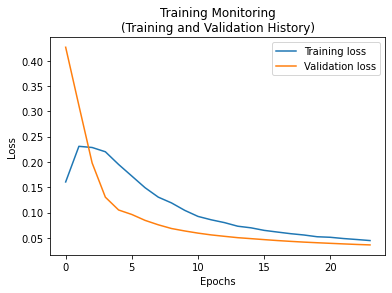

In [28]:
plt.plot(loss_tr, label='Training loss')
plt.plot(dev_loss, label='Validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Monitoring\n(Training and Validation History)')
plt.legend()
plt.show()

Compute accuracy, precision, recall and F1-Score:

In [29]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) + 1  
            for x,y in zip(X_te,Y_te)]
print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

Accuracy: 0.8487208008898777
Precision: 0.8499965353047955
Recall: 0.8486882199925678
F1-Score: 0.8484165767369


##### Answer
Accroding to the results of training monitoring results, I can conduct that the model is about to right.

- It can be shown that both training loss and validation loss is decreasing with the increasing of the number of epoch, and at the end they both are close to a steady state.



The way to prevent overfiting applied in this model includes:
- Stoping the traning when previous validation loss - current validation loss < the tolerance

### Discuss how did you choose model hyperparameters ? 

The main hapyermeter is potential to be optimized should be learning rate, the embedding size and the drop out rate. Here the grid research for parameter will be chose to find the best hyperparameters. We used 0.005 and 0.05 for 2 times gap which can be used to find best value caused keeping the cure smooth and dont apper overfitting is fine, large learing rate may prevent  to get the best point which has lowest loss. for saving time we will not try small lr.

The second parameter is embedding size，larger dimision may provide better performance but consider the time of computing the value will only start 2 smaller value.

The third parameter is dropping out rate，dropout is a technique to drop selected neurons at any time during training. They are forever "right to drop out". This means that their contributions to downstream neurons are temporarily removed in the forward transfer, and any heavy updates will not therefore result in transferring neurons.

In [30]:
learning_rate_list = [0.05, 0.1]
embedding_size_list = [100, 50]
drop_out_rate_list = [0.4, 0.2]
test_score = []
all_list = []
hyper_list = []

for dim in embedding_size_list:
    for lr in learning_rate_list:
        for drop in drop_out_rate_list:
            W = network_weights(vocab_size=len(vocab), 
                    embedding_dim=dim, 
                    hidden_dim=[], 
                    num_classes=3, 
                    init_val = 0.5)
            
           # We replace the dim, drop and lr for each iter
            W, loss_tr, dev_loss = SGD(X_tr,Y_tr,W,X_dev=X_dev, Y_dev=Y_dev,lr=lr, dropout = drop,freeze_emb=False,tolerance=0.1,epochs=100,print_progress=True)           
            
            # Results and Scores
            preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y'])+1 for x,y in zip(X_test,test_label)]
            accuracy = accuracy_score(test_label,preds_te)
            precision = precision_score(Y_te,preds_te,average='macro')
            Recall =recall_score(Y_te,preds_te,average='macro')
            F_Score =f1_score(Y_te,preds_te,average='macro')
            score = [accuracy, precision, Recall,F_Score]
            
            test_score.append(accuracy)
            all_list.append([accuracy, precision, Recall, F_Score])
            hyper = [dim, lr, drop]
            hyper_list.append(hyper)
     

C:\Users\ZHOUQI~1\AppData\Local\Temp/ipykernel_35020/3525837224.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  random_X_tr = np.random.permutation(X_tr)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch: 0 | Training loss: 0.040225 | Validation loss: 0.962899
Epoch: 1 | Training loss: 0.047583 | Validation loss: 0.788973
Epoch: 2 | Training loss: 0.045126 | Validation loss: 0.650680
Epoch: 3 | Training loss: 0.032097 | Validation loss: 0.548039
Epoch: 4 | Training loss: 0.023102 | Validation loss: 0.507351
Finshed the traning at epoch:  4


C:\Users\ZHOUQI~1\AppData\Local\Temp/ipykernel_35020/3525837224.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  random_X_tr = np.random.permutation(X_tr)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch: 0 | Training loss: 0.049943 | Validation loss: 0.737909
Epoch: 1 | Training loss: 0.119797 | Validation loss: 0.602036
Epoch: 2 | Training loss: 0.173039 | Validation loss: 0.478191
Epoch: 3 | Training loss: 0.181846 | Validation loss: 0.398638
Finshed the traning at epoch:  3


C:\Users\ZHOUQI~1\AppData\Local\Temp/ipykernel_35020/3525837224.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  random_X_tr = np.random.permutation(X_tr)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch: 0 | Training loss: 0.041072 | Validation loss: 0.866025
Epoch: 1 | Training loss: 0.034650 | Validation loss: 0.732145
Epoch: 2 | Training loss: 0.022274 | Validation loss: 0.590582
Epoch: 3 | Training loss: 0.011377 | Validation loss: 0.557602
Finshed the traning at epoch:  3


C:\Users\ZHOUQI~1\AppData\Local\Temp/ipykernel_35020/3525837224.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  random_X_tr = np.random.permutation(X_tr)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch: 0 | Training loss: 0.072845 | Validation loss: 0.825306
Epoch: 1 | Training loss: 0.073937 | Validation loss: 0.731487
Finshed the traning at epoch:  1


C:\Users\ZHOUQI~1\AppData\Local\Temp/ipykernel_35020/3525837224.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  random_X_tr = np.random.permutation(X_tr)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch: 0 | Training loss: 0.203075 | Validation loss: 0.396989
Epoch: 1 | Training loss: 0.168221 | Validation loss: 0.145552
Epoch: 2 | Training loss: 0.178989 | Validation loss: 0.079719
Finshed the traning at epoch:  2


C:\Users\ZHOUQI~1\AppData\Local\Temp/ipykernel_35020/3525837224.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  random_X_tr = np.random.permutation(X_tr)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch: 0 | Training loss: 0.259696 | Validation loss: 0.939961
Epoch: 1 | Training loss: 0.431602 | Validation loss: 0.895433
Finshed the traning at epoch:  1


C:\Users\ZHOUQI~1\AppData\Local\Temp/ipykernel_35020/3525837224.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  random_X_tr = np.random.permutation(X_tr)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch: 0 | Training loss: 0.580925 | Validation loss: 0.740849
Epoch: 1 | Training loss: 0.915608 | Validation loss: 0.741267
Finshed the traning at epoch:  1


C:\Users\ZHOUQI~1\AppData\Local\Temp/ipykernel_35020/3525837224.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  random_X_tr = np.random.permutation(X_tr)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch: 0 | Training loss: 0.403327 | Validation loss: 0.962011
Epoch: 1 | Training loss: 0.448352 | Validation loss: 1.056993
Finshed the traning at epoch:  1


In [31]:
hyper_list,  test_score

([[100, 0.05, 0.4],
  [100, 0.05, 0.2],
  [100, 0.1, 0.4],
  [100, 0.1, 0.2],
  [50, 0.05, 0.4],
  [50, 0.05, 0.2],
  [50, 0.1, 0.4],
  [50, 0.1, 0.2]],
 [0.8498331479421579,
  0.8442714126807565,
  0.8476084538375973,
  0.8409343715239155,
  0.8387096774193549,
  0.8398220244716351,
  0.8364849833147943,
  0.8387096774193549])

In [32]:
best_result = max(test_score)
best_id = test_score.index(best_result)
best_hyper = hyper_list[best_id]
best_S = all_list[best_id]
print("The best parameter and the F1-score on test set")
print("emb_dim:", best_hyper[0], " lr:", best_hyper[1]," drop_rate:" ,best_hyper[2] ," Accuracy:", best_result, "A/P/R/F",best_S)

The best parameter and the F1-score on test set
emb_dim: 100  lr: 0.05  drop_rate: 0.4  Accuracy: 0.8498331479421579 A/P/R/F [0.8498331479421579, 0.8527484467627605, 0.8498179115570421, 0.8497295462748925]


 | Embediing Size  | Learning Rate  | Drop Rate  | Accuracy
|:-:|:-:|:-:|:-:|
| 100 |0.05| 0.4 |0.8431590656284761   |
| 100| 0.05| 0.2  | 0.8431590656284761 |
| 100| 0.5| 0.4 |  0.8542825361512792  |
|100 |0.5| 0.2|    0.8609566184649611   |
|  50|0.05| 0.4 | 0.8453837597330367  |
| 50| 0.05| 0.2  |  0.8398220244716351 |
|50| 0.5|0.4  |    0.8431590656284761 |
|50| 0.5| 0.2|    0.8375973303670745  |

# Use Pre-trained Embeddings

Now re-train the network using GloVe pre-trained embeddings. You need to modify the `backward_pass` function above to stop computing gradients and updating weights of the embedding matrix.

Use the function below to obtain the embedding martix for your vocabulary. Generally, that should work without any problem. If you get errors, you can modify it.

In [33]:
def get_glove_embeddings(f_zip, f_txt, word2id, emb_size=300):
    w_emb = np.zeros((len(word2id), emb_size))
    with zipfile.ZipFile(f_zip) as z:
        with z.open(f_txt) as f:
            for line in f:
                line = line.decode('utf-8')
                word = line.split()[0]
                     
                if word in vocab:
                    emb = np.array(line.strip('\n').split()[1:]).astype(np.float32)
                    w_emb[word2id[word]] +=emb
    return w_emb

In [34]:
w_glove = get_glove_embeddings("glove.840B.300d.zip","glove.840B.300d.txt",word2id)

In [35]:
w_glove

array([[ 0.17918   , -0.058017  ,  0.11322   , ..., -0.65189999,
         0.20111001, -0.18035001],
       [ 0.10422   , -0.017546  ,  0.27474001, ..., -0.051732  ,
         0.078582  ,  0.43794999],
       [-0.37022001, -0.056673  , -0.53773999, ...,  0.12740999,
         0.45063999, -0.21357   ],
       ...,
       [-0.43382999, -0.15577   ,  0.078257  , ...,  0.076123  ,
         0.32749   ,  0.56278998],
       [ 0.12955999,  0.094718  , -0.17502999, ...,  0.090686  ,
        -0.027655  , -0.39662001],
       [ 0.22408   ,  0.23710001,  0.093534  , ..., -0.070376  ,
         0.097203  , -0.019966  ]])

In [36]:
w_glove.shape

(2000, 300)

First, initialise the weights of your network using the `network_weights` function. Second, replace the weigths of the embedding matrix with `w_glove`. Finally, train the network by freezing the embedding weights: 

In [37]:
# Initialise the weights of your network 
W = network_weights(vocab_size=len(vocab),embedding_dim=300,hidden_dim=[], num_classes=3, init_val = 0.1)

#Replace the weigths of the embedding matrix with w_glove
W[0] = w_glove

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

W, loss_tr, dev_loss = SGD(X_tr,Y_tr,W,X_dev=X_dev, Y_dev=Y_dev,lr=0.01,
                                       dropout = drop,freeze_emb = True,tolerance=0.001,epochs=100)


Shape W0 (2000, 300)
Shape W1 (300, 3)


C:\Users\ZHOUQI~1\AppData\Local\Temp/ipykernel_35020/3525837224.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  random_X_tr = np.random.permutation(X_tr)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch: 0 | Training loss: 0.674984 | Validation loss: 0.361958
Epoch: 1 | Training loss: 0.562877 | Validation loss: 0.171472
Epoch: 2 | Training loss: 0.519238 | Validation loss: 0.103691
Epoch: 3 | Training loss: 0.499299 | Validation loss: 0.071378
Epoch: 4 | Training loss: 0.489538 | Validation loss: 0.053146
Epoch: 5 | Training loss: 0.484958 | Validation loss: 0.041697
Epoch: 6 | Training loss: 0.483320 | Validation loss: 0.033958
Epoch: 7 | Training loss: 0.483460 | Validation loss: 0.028439
Epoch: 8 | Training loss: 0.484708 | Validation loss: 0.024338
Epoch: 9 | Training loss: 0.486651 | Validation loss: 0.021192
Epoch: 10 | Training loss: 0.489017 | Validation loss: 0.018713
Epoch: 11 | Training loss: 0.491625 | Validation loss: 0.016719
Epoch: 12 | Training loss: 0.494349 | Validation loss: 0.015084
Epoch: 13 | Training loss: 0.497100 | Validation loss: 0.013723
Epoch: 14 | Training loss: 0.499816 | Validation loss: 0.012575
Epoch: 15 | Training loss: 0.502452 | Validation l

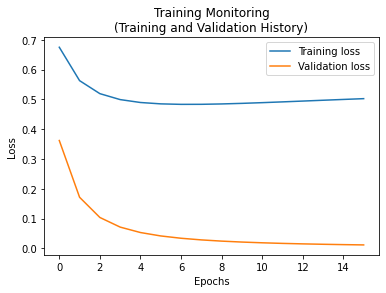

In [38]:
plt.plot(loss_tr, label='Training loss')
plt.plot(dev_loss, label='Validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Monitoring\n(Training and Validation History)')
plt.legend()
plt.show()

In [39]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y'] ) + 1  
            for x,y in zip(X_te,Y_te)]

print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

Accuracy: 0.8720800889877642
Precision: 0.8742475813052785
Recall: 0.8720624303232999
F1-Score: 0.8719213368715802


##### Answer
Accroding to the results of training monitoring results, I can conduct that the model is about to right.

- It can be shown that both training loss and validation loss is decreasing with the increasing of the number of epoch, and at the end they both are close to a steady state.



The way to prevent overfiting applied in this model includes:
- Stoping the traning when previous validation loss - current validation loss < the tolerance

### Discuss how did you choose model hyperparameters ? 
The main hapyermeter is potential to be optimized should be learning rate, the embedding size and the drop out rate. Here the grid research for parameter will be chose to find the best hyperparameters. We used 0.005 and 0.05 for 2 times gap which can be used to find best value caused keeping the cure smooth and dont apper overfitting is fine, large learing rate may prevent  to get the best point which has lowest loss.

The second parameter is embedding size，but here the size will be fixed to 300 because it is  pre-trained embeddings which limit the option.

The third parameter is dropping out rate，dropout is a technique to drop selected neurons at any time during training. They are forever "right to drop out". This means that their contributions to downstream neurons are temporarily removed in the forward transfer, and any heavy updates will not therefore result in transferring neurons.

In [40]:
learning_rate_list = [0.05, 0.1]
drop_out_rate_list = [0.4, 0.2]
test_score = []
hyper_list = []
all_list = []

for lr in learning_rate_list:
    for drop in drop_out_rate_list:
        # Initialise the weights of your network 
        W = network_weights(vocab_size=len(vocab),embedding_dim=300,hidden_dim=[], num_classes=3, init_val = 0.1)
            #Replace the weigths of the embedding matrix with w_glove
        W[0] = w_glove
        W, loss_tr, dev_loss = SGD(X_tr,Y_tr,W,X_dev=X_dev, Y_dev=Y_dev,lr=lr, dropout = drop,freeze_emb=False,tolerance=0.01,epochs=100,print_progress=True)
   
        preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y'])+1 for x,y in zip(X_tr,train_label)]
        tr_f1 = f1_score(train_label,preds_te,average='macro')
            
        preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y'])+1 for x,y in zip(X_test,test_label)]
        accuracy = accuracy_score(test_label,preds_te)
        precision = precision_score(Y_te,preds_te,average='macro')
        Recall =recall_score(Y_te,preds_te,average='macro')
        F_Score =f1_score(Y_te,preds_te,average='macro')
        score = [accuracy, precision, Recall,F_Score]
            
        test_score.append(accuracy)
        all_list.append([accuracy, precision, Recall, F_Score])
        hyper = [dim, lr, drop]
        hyper_list.append(hyper)

C:\Users\ZHOUQI~1\AppData\Local\Temp/ipykernel_35020/3525837224.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  random_X_tr = np.random.permutation(X_tr)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch: 0 | Training loss: 0.191389 | Validation loss: 0.070912
Epoch: 1 | Training loss: 0.362849 | Validation loss: 0.048633
Epoch: 2 | Training loss: 0.579950 | Validation loss: 0.026201
Epoch: 3 | Training loss: 0.831632 | Validation loss: 0.014210
Epoch: 4 | Training loss: 0.993882 | Validation loss: 0.009329
Finshed the traning at epoch:  4


C:\Users\ZHOUQI~1\AppData\Local\Temp/ipykernel_35020/3525837224.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  random_X_tr = np.random.permutation(X_tr)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch: 0 | Training loss: 0.329009 | Validation loss: 0.118508
Epoch: 1 | Training loss: 0.671873 | Validation loss: 0.131506
Finshed the traning at epoch:  1


C:\Users\ZHOUQI~1\AppData\Local\Temp/ipykernel_35020/3525837224.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  random_X_tr = np.random.permutation(X_tr)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch: 0 | Training loss: 0.218782 | Validation loss: 0.066782
Epoch: 1 | Training loss: 0.395775 | Validation loss: 0.018998
Epoch: 2 | Training loss: 0.824203 | Validation loss: 0.006315
Epoch: 3 | Training loss: 1.118439 | Validation loss: 0.003790
Finshed the traning at epoch:  3


C:\Users\ZHOUQI~1\AppData\Local\Temp/ipykernel_35020/3525837224.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  random_X_tr = np.random.permutation(X_tr)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch: 0 | Training loss: 0.406845 | Validation loss: 0.366495
Epoch: 1 | Training loss: 0.564364 | Validation loss: 0.347933
Epoch: 2 | Training loss: 0.782263 | Validation loss: 0.111422
Epoch: 3 | Training loss: 1.083740 | Validation loss: 0.076951
Epoch: 4 | Training loss: 1.306805 | Validation loss: 0.053391
Epoch: 5 | Training loss: 1.347888 | Validation loss: 0.038957
Epoch: 6 | Training loss: 1.320577 | Validation loss: 0.031991
Finshed the traning at epoch:  6


In [41]:
hyper_list,  test_score

([[50, 0.05, 0.4], [50, 0.05, 0.2], [50, 0.1, 0.4], [50, 0.1, 0.2]],
 [0.8776418242491657,
  0.8687430478309233,
  0.8787541713014461,
  0.8765294771968855])

In [42]:
best_result = max(test_score)
best_id = test_score.index(best_result)
best_hyper = hyper_list[best_id]
best_S = all_list[best_id]
print("The best parameter and the F1-score on test set")
print("emb_dim:", best_hyper[0], " lr:", best_hyper[1]," drop_rate:" ,best_hyper[2] ," Accuracy:", best_result, "A/P/R/F",best_S)

The best parameter and the F1-score on test set
emb_dim: 50  lr: 0.1  drop_rate: 0.4  Accuracy: 0.8787541713014461 A/P/R/F [0.8787541713014461, 0.8803713043717237, 0.8787328130806392, 0.8788150875916833]


# Extend to support deeper architectures 

Extend the network to support back-propagation for more hidden layers. You need to modify the `backward_pass` function above to compute gradients and update the weights between intermediate hidden layers. Finally, train and evaluate a network with a deeper architecture. Do deeper architectures increase performance?

In [43]:
W = network_weights(vocab_size=len(vocab),embedding_dim=300,hidden_dim=[200,100],num_classes=3, init_val = 0.1)
W[0] = w_glove
for i in range(len(W)):
    print('Shape of W'+str(i), W[i].shape)
    
W, loss_tr, dev_loss = SGD(X_tr,Y_tr,W,X_dev=X_dev, Y_dev=Y_dev,lr= 0.001,dropout=0.2,freeze_emb=True,print_progress=True,
tolerance=0.00001,epochs=30)


Shape of W0 (2000, 300)
Shape of W1 (300, 200)
Shape of W2 (200, 100)
Shape of W3 (100, 3)


C:\Users\ZHOUQI~1\AppData\Local\Temp/ipykernel_35020/3525837224.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  random_X_tr = np.random.permutation(X_tr)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch: 0 | Training loss: 1.111849 | Validation loss: 1.089938
Epoch: 1 | Training loss: 1.116640 | Validation loss: 1.079622
Epoch: 2 | Training loss: 1.120942 | Validation loss: 1.067020
Epoch: 3 | Training loss: 1.123744 | Validation loss: 1.050615
Epoch: 4 | Training loss: 1.124009 | Validation loss: 1.030120
Epoch: 5 | Training loss: 1.118252 | Validation loss: 1.002810
Epoch: 6 | Training loss: 1.101078 | Validation loss: 0.967197
Epoch: 7 | Training loss: 1.064956 | Validation loss: 0.911959
Epoch: 8 | Training loss: 1.001134 | Validation loss: 0.811564
Epoch: 9 | Training loss: 0.905047 | Validation loss: 0.641497
Epoch: 10 | Training loss: 0.777009 | Validation loss: 0.417465
Epoch: 11 | Training loss: 0.630871 | Validation loss: 0.219096
Epoch: 12 | Training loss: 0.483077 | Validation loss: 0.102057
Epoch: 13 | Training loss: 0.358980 | Validation loss: 0.051067
Epoch: 14 | Training loss: 0.268189 | Validation loss: 0.029754
Epoch: 15 | Training loss: 0.209031 | Validation l

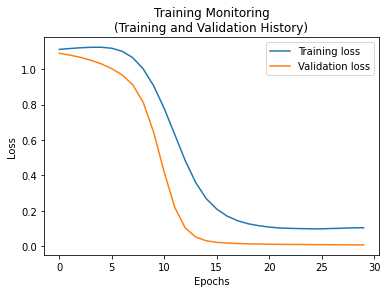

In [44]:
plt.plot(loss_tr, label='Training loss')
plt.plot(dev_loss, label='Validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Monitoring\n(Training and Validation History)')
plt.legend()
plt.show()

In [45]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) + 1 
            for x,y in zip(X_te,Y_te)]

print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

Accuracy: 0.882091212458287
Precision: 0.882560747846966
Recall: 0.8820475659606094
F1-Score: 0.8816999982916723


### Discuss how did you choose model hyperparameters ? 
The strategies is similar as the previous work, but for saving time we don't too many search.

In [52]:
learning_rate_list = [0.001,0.01,0.05]
drop_out_rate_list = [0.2, 0.4 ]
test_score = []
hyper_list = []
all_list = []

for lr in learning_rate_list:
    for drop in drop_out_rate_list:
        W = network_weights(vocab_size=len(vocab),embedding_dim=300,hidden_dim=[20,100],num_classes=3, init_val = 0.1)
            #Replace the weigths of the embedding matrix with w_glove
        W[0] = w_glove
        W, loss_tr, dev_loss = SGD(X_tr,Y_tr,W,X_dev=X_dev, Y_dev=Y_dev,lr=lr, 
                                   dropout = drop,freeze_emb=False,tolerance=0.1,epochs=100,print_progress=True)    
        # Results and Scores
        preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y'])+1 for x,y in zip(X_test,test_label)]
        accuracy = accuracy_score(test_label,preds_te)
        precision = precision_score(Y_te,preds_te,average='macro')
        Recall =recall_score(Y_te,preds_te,average='macro')
        F_Score =f1_score(Y_te,preds_te,average='macro')
        score = [accuracy, precision, Recall,F_Score]
            
        test_score.append(accuracy)
        all_list.append([accuracy, precision, Recall, F_Score])
        hyper = [dim, lr, drop]
        hyper_list.append(hyper)

C:\Users\ZHOUQI~1\AppData\Local\Temp/ipykernel_35020/3525837224.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  random_X_tr = np.random.permutation(X_tr)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch: 0 | Training loss: 1.100476 | Validation loss: 1.096907
Epoch: 1 | Training loss: 1.101698 | Validation loss: 1.094838
Finshed the traning at epoch:  1


C:\Users\ZHOUQI~1\AppData\Local\Temp/ipykernel_35020/3525837224.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  random_X_tr = np.random.permutation(X_tr)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch: 0 | Training loss: 1.096895 | Validation loss: 1.101516
Epoch: 1 | Training loss: 1.096863 | Validation loss: 1.101377
Finshed the traning at epoch:  1


C:\Users\ZHOUQI~1\AppData\Local\Temp/ipykernel_35020/3525837224.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  random_X_tr = np.random.permutation(X_tr)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch: 0 | Training loss: 1.105520 | Validation loss: 1.055663
Epoch: 1 | Training loss: 0.600050 | Validation loss: 0.156953
Epoch: 2 | Training loss: 0.054986 | Validation loss: 0.022260
Epoch: 3 | Training loss: 0.029745 | Validation loss: 0.007896
Finshed the traning at epoch:  3


C:\Users\ZHOUQI~1\AppData\Local\Temp/ipykernel_35020/3525837224.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  random_X_tr = np.random.permutation(X_tr)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch: 0 | Training loss: 1.097052 | Validation loss: 1.100205
Epoch: 1 | Training loss: 1.096117 | Validation loss: 1.099829
Finshed the traning at epoch:  1


C:\Users\ZHOUQI~1\AppData\Local\Temp/ipykernel_35020/3525837224.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  random_X_tr = np.random.permutation(X_tr)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch: 0 | Training loss: 0.050567 | Validation loss: 0.000536
Epoch: 1 | Training loss: 0.100792 | Validation loss: 0.004568
Finshed the traning at epoch:  1


C:\Users\ZHOUQI~1\AppData\Local\Temp/ipykernel_35020/3525837224.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  random_X_tr = np.random.permutation(X_tr)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch: 0 | Training loss: 1.011191 | Validation loss: 1.105835
Epoch: 1 | Training loss: 0.018106 | Validation loss: 0.253464
Epoch: 2 | Training loss: 0.006815 | Validation loss: 2.840771
Finshed the traning at epoch:  2


In [53]:
best_result = max(test_score)
best_id = test_score.index(best_result)
best_hyper = hyper_list[best_id]
best_S = all_list[best_id]
print("The best parameter and the F1-score on test set")
print("emb_dim:", best_hyper[0], " lr:", best_hyper[1]," drop_rate:" ,best_hyper[2] ," Accuracy:", best_result, "A/P/R/F",best_S)

The best parameter and the F1-score on test set
emb_dim: 50  lr: 0.05  drop_rate: 0.2  Accuracy: 0.8798665183537263 A/P/R/F [0.8798665183537263, 0.8831812314735394, 0.8798587885544408, 0.88013387672361]


## Full Results

Add your final results here:

| Model | Precision  | Recall  | F1-Score  | Accuracy
|:-:|:-:|:-:|:-:|:-:|
| Average Embedding  | 0.8527484467627605| 0.8498179115570421| 0.8497295462748925|0.8498331479421579|
| Average Embedding (Pre-trained)  | 0.8803713043717237 | 0.8787328130806392 |0.8788150875916833|0.8787541713014461|
| Average Embedding (Pre-trained) + X hidden layers    | 0.882560747846966  | 0.8820475659606094  |  0.8816999982916723  |  0.882091212458287 |

Precision: 
Recall: 
F1-Score:

Please discuss why your best performing model is better than the rest.

The results of table clear show that the Average Embedding (Pre-trained) + X hidden layers > Average Embedding (Pre-trained) > Average Embedding.

This is reasonable result because Pre_trained model embedding W matrix was train by a large text corpus so it should have better geralization ability and have a better initilization on model when trained.

Deeper architectures architectures has more layers can generate more detials features， the deeper network can also provide modeling of complex nonlinear systems(like this classification NLP problem), and the additional layers provide a higher level of abstraction for the model, thus improving the ability of the model. However this may also have significant increase on the complexity. That may be the reason that we failed to have a large optimisation on grid search.

In general, all model have accurcy higher than 85%， they are all avaliable and preformed good.